# Augment the dfata, classify using transfer learning
* Load the data
* Load pre-trained model MobileNetV3Small
* Fit the classifier including the pre-trained model and a dense network
* Save the fitted classifier

In [37]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, BatchNormalization, RandomBrightness, RandomFlip, RandAugment, Resizing
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
from os.path import join
import pickle
from sklearn.model_selection import train_test_split

from PIL import Image, ImageOps

%matplotlib inline
import matplotlib.pyplot as plt

Global variables

In [2]:
DATA_PATH = 'data'
MODELS_PATH = 'models'

In [3]:
# input image dimensions
input_width = 300
input_height = 300
input_depth = 3
input_dim = input_width*input_height*input_depth
input_shape = (input_width, input_height, input_depth)

# classification classes
output_classes = 7

# size of sample used to train the model
NUM_SAMPLES = 1000

# Rescale the data (color) values
scale = False  # rather not

## Load the data
* Load the data prepared in previous notebook
* Optionally subsample the data for faster training during try-outs
* Optionally rescale the image data, one-hot encode the labels
* Display some images for checking

Load the data prepared in previous notebook

In [4]:
with np.load(join(DATA_PATH, 'train_data.npz')) as data:
    data_dict=dict(data.items())
X_train = data_dict['X']
y_train = data_dict['y']

Optionally subsample the data for faster training during try-outs

In [5]:
import random

# Get a smaller random sample 
idx = random.sample(range(len(X_train)-1), NUM_SAMPLES)
X_train_rnd = X_train[idx]
y_train_rnd = y_train[idx]

In [6]:
X_train_preprocessed = X_train_rnd

# convert str names to class integer indices
classes, y_train_classes = np.unique(y_train_rnd, return_inverse=True)
y_train_preprocessed = to_categorical(y_train_classes, num_classes=output_classes)

print('Train:', X_train_preprocessed.shape)

Train: (1000, 300, 300, 3)


Display some images for checking

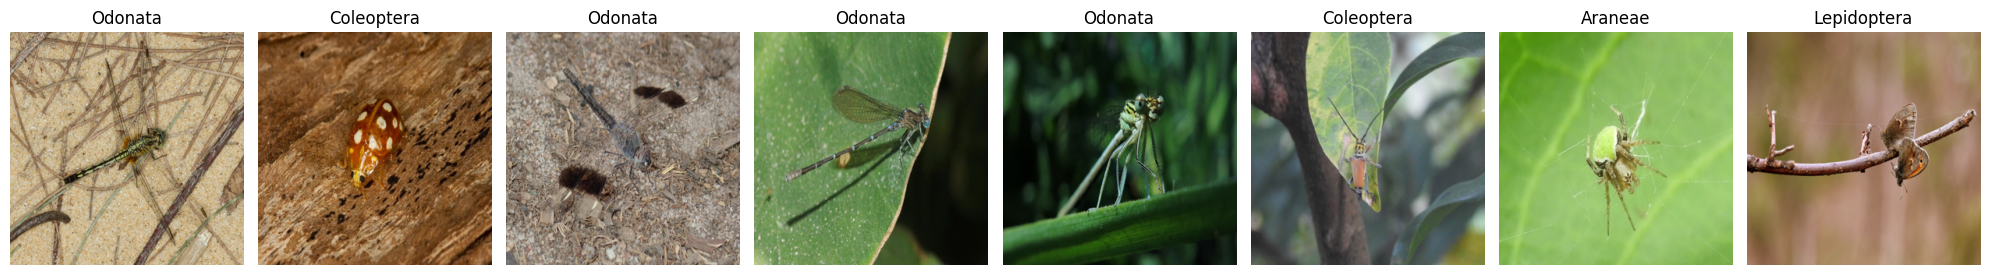

In [7]:
check_images = 8
idx = random.sample(range(len(X_train_preprocessed)-1), check_images)
fig, ax = plt.subplots(1, check_images, figsize=(20, 10))
for i, id in enumerate(idx):
    data = X_train_preprocessed[id].astype('uint8')
    img = Image.fromarray(data, 'RGB')
    ax[i].imshow(img)
    ax[i].set_title(classes[y_train_classes[id]])
    ax[i].axis('off')
plt.tight_layout()
plt.show();

## Transfer learning with MobileNet
* Load pre-trained model
* Define the classifier
* Fit the classifier

In [35]:
backbone = tf.keras.applications.MobileNetV3Small(
    input_shape=(input_width, input_height, input_depth),
    alpha=1.0,
    minimalistic=True,
    include_top=False,
    weights='imagenet',
    dropout_rate=0.2,
    include_preprocessing=True
)
backbone.trainable = False

Define the local model

In [53]:
input = Input(shape=(input_width, input_height, input_depth))

x = RandAugment()(input)
x = backbone(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.05)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.05)(x)
x = BatchNormalization()(x)

output = Dense(output_classes, activation='softmax')(x)

model = Model(input, output)
model.summary()

ValueError: Input 0 of layer "inception_v3" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 300, 300, 3)

In [27]:
loss_function = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name='accuracy')]
model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss = loss_function,
    metrics = metrics
)

## Fit the model

In [30]:
%%time

tf.config.run_functions_eagerly(True)
callback = EarlyStopping(monitor='val_accuracy', patience=5)
# Fit model
history = model.fit(
    x=X_train_preprocessed, y=y_train_preprocessed,
    validation_split=0.2,
    batch_size=32, epochs=30,
    callbacks=[callback] 
)

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 950ms/step - accuracy: 0.6315 - loss: 0.9905 - val_accuracy: 0.5000 - val_loss: 1.4032
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 940ms/step - accuracy: 0.6617 - loss: 0.9377 - val_accuracy: 0.5100 - val_loss: 1.4135
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 942ms/step - accuracy: 0.6691 - loss: 0.9428 - val_accuracy: 0.4900 - val_loss: 1.4362
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 939ms/step - accuracy: 0.7265 - loss: 0.7807 - val_accuracy: 0.5750 - val_loss: 1.3461
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 942ms/step - accuracy: 0.6917 - loss: 0.8581 - val_accuracy: 0.5200 - val_loss: 1.5276
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 938ms/step - accuracy: 0.6640 - loss: 0.9149 - val_accuracy: 0.5000 - val_loss: 1.5558
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 938ms/step - accuracy: 0.7244 - loss: 0.7647 - val_accuracy: 0.4950 - val_loss: 1.6095
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 929ms/step - accuracy: 0.7608 - loss: 0.6881 - val_accu

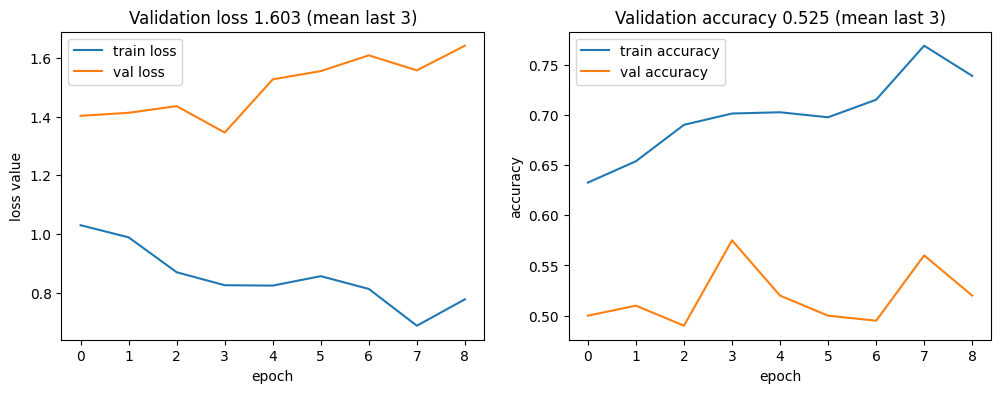

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot accuracy values
ax1.plot(history.history['loss'], label='train loss')
ax1.plot(history.history['val_loss'], label='val loss')
ax1.set_title('Validation loss {:.3f} (mean last 3)'.format(
    np.mean(history.history['val_loss'][-3:]) # last three values
))
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss value')
ax1.legend()

# Plot accuracy values
ax2.plot(history.history['accuracy'], label='train accuracy')
ax2.plot(history.history['val_accuracy'], label='val accuracy')
ax2.set_title('Validation accuracy {:.3f} (mean last 3)'.format(
    np.mean(history.history['val_accuracy'][-3:]) # last three values
))
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()
plt.show()


## Save the model

In [16]:
with open(join(MODELS_PATH, 'transfer_mobilenet_augmented.pickle'), 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)